/Users/bob/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


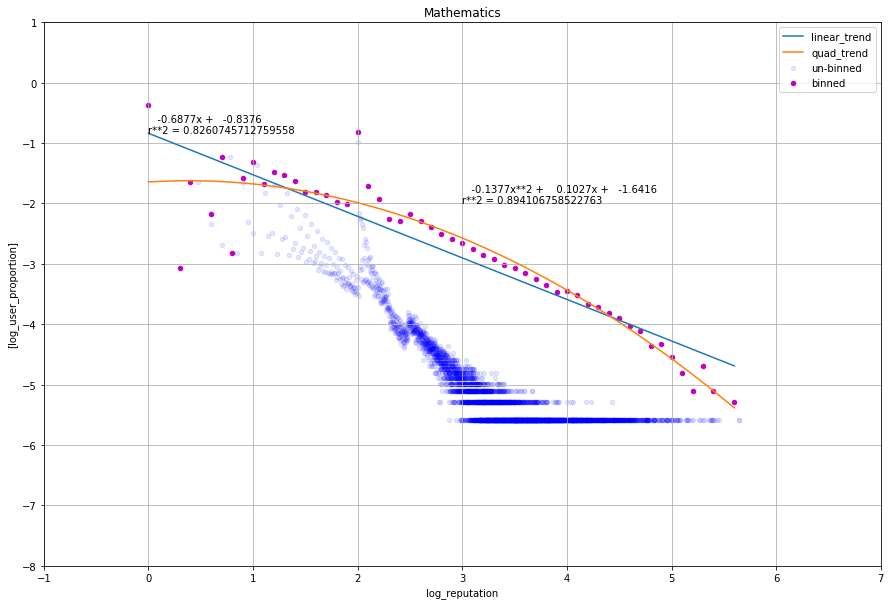

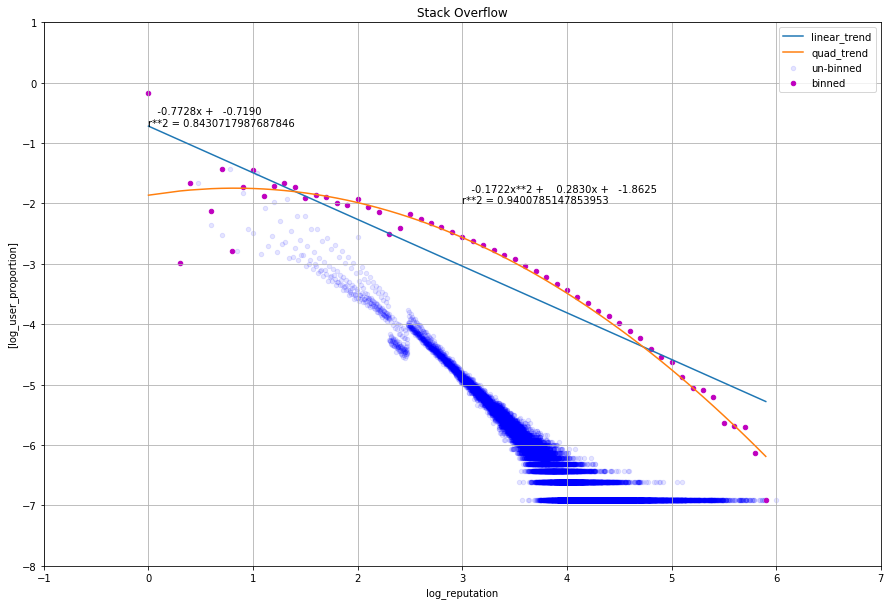

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

def plot_hist(df,alpha,c,label, ax=None, limits = [-1,7,-8,1], trends=False):

    ax = df.plot(x='log_reputation',
                 y=['log_user_proportion'],
                 kind='scatter',
                 alpha=alpha,
                 ax=ax,
                 color=c,edgecolor=c,
                label=label,
                figsize=(15.0, 10.0))
    if trends:
        X = df.log_reputation
        X = sm.add_constant(X)
        model = sm.OLS(df.log_user_proportion, X)
        results = model.fit()
        df['linear_trend'] = results.fittedvalues
        plt.text(df.log_reputation.min(),df.linear_trend.max(),
                 '{log_reputation:10.4f}x +{const:10.4f}'.format(**results.params)+
                '\nr**2 = {}'.format(results.rsquared))

        X = np.column_stack((df.log_reputation, df.log_reputation**2))
        X = sm.add_constant(X)
        model = sm.OLS(df.log_user_proportion, X)
        results = model.fit()
        df['quad_trend'] = results.fittedvalues

        plt.text(3,-2,
                 '{x2:10.4f}x**2 +{x1:10.4f}x +{const:10.4f}'.format(**results.params)+
                '\nr**2 = {}'.format(results.rsquared))
        ax = df.plot(x='log_reputation',
                     y=['linear_trend','quad_trend'],
                     kind='line',
                     alpha=1,
                     ax=ax)
    plt.axis(limits)
    plt.grid(True)
    return ax


def process_df(url):
    df = pd.read_csv(url,names=['Reputation','UserCount'],dtype=float,skiprows=1)
    df['user_proportion'] = df.UserCount/sum(df.UserCount)
    df['log_user_proportion'] = np.log10(df.user_proportion)
    df['log_reputation'] = np.log10(df.Reputation)
    ax = plot_hist(df,.1,c='b',label='un-binned')


    cut_points = np.power(10,np.arange(0,8,.1))
    bins = pd.cut(df.Reputation,cut_points,right=False)
    df = df.groupby(bins).user_proportion.sum().reset_index()
    df['cut_points'] = cut_points[:-1]
    df.dropna(inplace=True)
    df['log_reputation'] = np.log10(df.cut_points)
    df['log_user_proportion'] = np.log10(df.user_proportion)
    plot_hist(df,1,c='m',ax=ax,label='binned',trends=True)
    plt.legend()
    return df

df = process_df('http://data.stackexchange.com/math/csv/715124')
plt.title('Mathematics')
df2 = process_df('https://data.stackexchange.com/stackoverflow/csv/715082')
plt.title('Stack Overflow')